In [1]:
# # Author: Bichen Wu (bichen@berkeley.edu) 02/27/2017

# """The data base wrapper class"""

# import os
# import random
# import shutil

# import numpy as np

# from utils.util import *

# class imdb(object):
#   """Image database."""

#   def __init__(self, name, mc):
#     self._name = name
#     self._image_set = []
#     self._image_idx = []
#     self._data_root_path = []
#     self.mc = mc

#     # batch reader
#     self._perm_idx = []
#     self._cur_idx = 0

#   @property
#   def name(self):
#     return self._name

#   @property
#   def image_idx(self):
#     return self._image_idx

#   @property
#   def image_set(self):
#     return self._image_set

#   @property
#   def data_root_path(self):
#     return self._data_root_path

#   def _shuffle_image_idx(self):
#     self._perm_idx = [self._image_idx[i] for i in
#         np.random.permutation(np.arange(len(self._image_idx)))]
#     self._cur_idx = 0

#   def read_batch(self, shuffle=True):
#     """Read a batch of lidar data including labels. Data formated as numpy array
#     of shape: height x width x {x, y, z, intensity, range, label}.
#     Args:
#       shuffle: whether or not to shuffle the dataset
#     Returns:
#       lidar_per_batch: LiDAR input. Shape: batch x height x width x 5.
#       lidar_mask_per_batch: LiDAR mask, 0 for missing data and 1 otherwise.
#         Shape: batch x height x width x 1.
#       label_per_batch: point-wise labels. Shape: batch x height x width.
#       weight_per_batch: loss weights for different classes. Shape: 
#         batch x height x width
#     """
#     mc = self.mc

#     if shuffle:
#       if self._cur_idx + mc.BATCH_SIZE >= len(self._image_idx):
#         self._shuffle_image_idx()
#       batch_idx = self._perm_idx[self._cur_idx:self._cur_idx+mc.BATCH_SIZE]
#       self._cur_idx += mc.BATCH_SIZE
#     else:
#       if self._cur_idx + mc.BATCH_SIZE >= len(self._image_idx):
#         batch_idx = self._image_idx[self._cur_idx:] \
#             + self._image_idx[:self._cur_idx + mc.BATCH_SIZE-len(self._image_idx)]
#         self._cur_idx += mc.BATCH_SIZE - len(self._image_idx)
#       else:
#         batch_idx = self._image_idx[self._cur_idx:self._cur_idx+mc.BATCH_SIZE]
#         self._cur_idx += mc.BATCH_SIZE

#     lidar_per_batch = []
#     lidar_mask_per_batch = []
#     label_per_batch = []
#     weight_per_batch = []

#     for idx in batch_idx:
#       # load data
#       # loading from npy is 30x faster than loading from pickle
#       record = np.load(self._lidar_2d_path_at(idx)).astype(np.float32, copy=False)

#       if mc.DATA_AUGMENTATION:
#         if mc.RANDOM_FLIPPING:
#           if np.random.rand() > 0.5:
#             # flip y
#             record = record[:, ::-1, :]
#             record[:, :, 1] *= -1

#       lidar = record[:, :, :5] # x, y, z, intensity, depth
#       lidar_mask = np.reshape(
#           (lidar[:, :, 4] > 0), 
#           [mc.ZENITH_LEVEL, mc.AZIMUTH_LEVEL, 1]
#       )
#       # normalize
#       lidar = (lidar - mc.INPUT_MEAN)/mc.INPUT_STD

#       label = record[:, :, 5]
#       weight = np.zeros(label.shape)
#       for l in range(mc.NUM_CLASS):
#         weight[label==l] = mc.CLS_LOSS_WEIGHT[int(l)]

#       # Append all the data
#       lidar_per_batch.append(lidar)
#       lidar_mask_per_batch.append(lidar_mask)
#       label_per_batch.append(label)
#       weight_per_batch.append(weight)

#     return np.array(lidar_per_batch), np.array(lidar_mask_per_batch), \
#         np.array(label_per_batch), np.array(weight_per_batch)

#   def evaluate_detections(self):
#     raise NotImplementedError


In [2]:
# # Author: Bichen Wu (bichen@berkeley.edu) 02/27/2017

# """Image data base class for kitti"""

# import os 
# import numpy as np
# import subprocess

# class kitti(imdb):
#   def __init__(self, image_set, data_path, mc):
#     imdb.__init__(self, 'kitti_'+image_set, mc)
#     self._image_set = image_set
#     self._data_root_path = data_path
#     self._lidar_2d_path = os.path.join(self._data_root_path, 'lidar_2d')
#     self._gta_2d_path = os.path.join(self._data_root_path, 'gta')

#     # a list of string indices of images in the directory
#     self._image_idx = self._load_image_set_idx() 
#     # a dict of image_idx -> [[cx, cy, w, h, cls_idx]]. x,y,w,h are not divided by
#     # the image width and height

#     ## batch reader ##
#     self._perm_idx = None
#     self._cur_idx = 0
#     # TODO(bichen): add a random seed as parameter
#     self._shuffle_image_idx()

#   def _load_image_set_idx(self):
#     image_set_file = os.path.join(
#         self._data_root_path, 'ImageSet', self._image_set+'.txt')
#     assert os.path.exists(image_set_file), \
#         'File does not exist: {}'.format(image_set_file)

#     with open(image_set_file) as f:
#       image_idx = [x.strip() for x in f.readlines()]
#     return image_idx

#   def _lidar_2d_path_at(self, idx):
#     if idx[:4] == 'gta_':
#       lidar_2d_path = os.path.join(self._gta_2d_path, idx+'.npy')
#     else:
#       lidar_2d_path = os.path.join(self._lidar_2d_path, idx+'.npy')

#     assert os.path.exists(lidar_2d_path), \
#         'File does not exist: {}'.format(lidar_2d_path)
#     return lidar_2d_path


In [3]:
# !pip3 install easydict

In [4]:
# #G Author: Bichen Wu (bichen@berkeley.edu) 02/20/2017

# """Base Model configurations"""

# import os
# import os.path as osp
# import numpy as np
# from easydict import EasyDict as edict

# def base_model_config(dataset='KITTI'):
#   assert dataset.upper()=='KITTI', \
#       'Currently only support KITTI dataset'

#   cfg = edict()

#   # Dataset used to train/val/test model. Now support KITTI
#   cfg.DATASET = dataset.upper()

#   # classes
#   cfg.CLASSES = [
#       'unknown',
#       'car',
#       'van',
#       'truck',
#       'pedestrian',
#       'person_sitting',
#       'cyclist',
#       'tram',
#       'misc',
#   ]

#   # number of classes
#   cfg.NUM_CLASS = len(cfg.CLASSES)

#   # dict from class name to id
#   cfg.CLS_2_ID = dict(zip(cfg.CLASSES, range(len(cfg.CLASSES))))

#   # loss weight for each class
#   cfg.CLS_LOSS_WEIGHT = np.array(
#       [1/20.0, 1.0,  2.0, 3.0,
#        8.0, 10.0, 8.0, 2.0, 1.0]
#   )

#   # rgb color for each class
#   cfg.CLS_COLOR_MAP = np.array(
#       [[ 0.00,  0.00,  0.00],
#        [ 0.12,  0.56,  0.37],
#        [ 0.66,  0.55,  0.71],
#        [ 0.58,  0.72,  0.88],
#        [ 0.25,  0.51,  0.76],
#        [ 0.98,  0.47,  0.73],
#        [ 0.40,  0.19,  0.10],
#        [ 0.87,  0.19,  0.17],
#        [ 0.13,  0.55,  0.63]]
#   )

#   # Probability to keep a node in dropout
#   cfg.KEEP_PROB = 0.5

#   # image width
#   cfg.IMAGE_WIDTH = 224

#   # image height
#   cfg.IMAGE_HEIGHT = 224

#   # number of vertical levels
#   cfg.NUM_LEVEL = 10

#   # number of pie sectors of the field of view
#   cfg.NUM_SECTOR = 90

#   # maximum distance of a measurement
#   cfg.MAX_DIST = 100.0

#   # batch size
#   cfg.BATCH_SIZE = 20

#   # Pixel mean values (BGR order) as a (1, 1, 3) array. Below is the BGR mean
#   # of VGG16
#   cfg.BGR_MEANS = np.array([[[103.939, 116.779, 123.68]]])

#   # Pixel mean values (BGR order) as a (1, 1, 3) array. Below is the BGR mean
#   # of VGG16
#   cfg.RGB_MEANS = np.array([[[123.68, 116.779, 103.939]]])

#   # reduce step size after this many steps
#   cfg.DECAY_STEPS = 10000

#   # multiply the learning rate by this factor
#   cfg.LR_DECAY_FACTOR = 0.1

#   # learning rate
#   cfg.LEARNING_RATE = 0.005

#   # momentum
#   cfg.MOMENTUM = 0.9

#   # weight decay
#   cfg.WEIGHT_DECAY = 0.0005

#   # wether to load pre-trained model
#   cfg.LOAD_PRETRAINED_MODEL = True

#   # path to load the pre-trained model
#   cfg.PRETRAINED_MODEL_PATH = ''

#   # print log to console in debug mode
#   cfg.DEBUG_MODE = False

#   # gradients with norm larger than this is going to be clipped.
#   cfg.MAX_GRAD_NORM = 10.0

#   # Whether to do data augmentation
#   cfg.DATA_AUGMENTATION = False

#   # The range to randomly shift the image widht
#   cfg.DRIFT_X = 0

#   # The range to randomly shift the image height
#   cfg.DRIFT_Y = 0

#   # small value used in batch normalization to prevent dividing by 0. The
#   # default value here is the same with caffe's default value.
#   cfg.BATCH_NORM_EPSILON = 1e-5

#   # small value used in denominator to prevent division by 0
#   cfg.DENOM_EPSILON = 1e-12

#   # capacity for tf.FIFOQueue
#   cfg.QUEUE_CAPACITY = 80

#   cfg.NUM_ENQUEUE_THREAD = 8

#   return cfg


In [5]:
# # Author: Bichen Wu (bichen@berkeley.edu) 08/25/2016

# """Model configuration for pascal dataset"""

# import numpy as np


# def kitti_squeezeSeg_config():
#   """Specify the parameters to tune below."""
#   mc                    = base_model_config('KITTI')

#   mc.CLASSES            = ['unknown', 'car', 'pedestrian', 'cyclist']
#   mc.NUM_CLASS          = len(mc.CLASSES)
#   mc.CLS_2_ID           = dict(zip(mc.CLASSES, range(len(mc.CLASSES))))
#   mc.CLS_LOSS_WEIGHT    = np.array([1/15.0, 1.0,  10.0, 10.0])
#   mc.CLS_COLOR_MAP      = np.array([[ 0.00,  0.00,  0.00],
#                                     [ 0.12,  0.56,  0.37],
#                                     [ 0.66,  0.55,  0.71],
#                                     [ 0.58,  0.72,  0.88]])

#   mc.BATCH_SIZE         = 8
#   mc.AZIMUTH_LEVEL      = 512
#   mc.ZENITH_LEVEL       = 64

#   mc.LCN_HEIGHT         = 3
#   mc.LCN_WIDTH          = 5
#   mc.RCRF_ITER          = 3
#   mc.BILATERAL_THETA_A  = np.array([.9, .9, .6, .6])
#   mc.BILATERAL_THETA_R  = np.array([.015, .015, .01, .01])
#   mc.BI_FILTER_COEF     = 0.1
#   mc.ANG_THETA_A        = np.array([.9, .9, .6, .6])
#   mc.ANG_FILTER_COEF    = 0.02

#   mc.CLS_LOSS_COEF      = 15.0
#   mc.WEIGHT_DECAY       = 0.0001
#   mc.LEARNING_RATE      = 0.01
#   mc.DECAY_STEPS        = 10000
#   mc.MAX_GRAD_NORM      = 1.0
#   mc.MOMENTUM           = 0.9
#   mc.LR_DECAY_FACTOR    = 0.5

#   mc.DATA_AUGMENTATION  = True
#   mc.RANDOM_FLIPPING    = True

#   # x, y, z, intensity, distance
#   mc.INPUT_MEAN         = np.array([[[10.88, 0.23, -1.04, 0.21, 12.12]]])
#   mc.INPUT_STD          = np.array([[[11.47, 6.91, 0.86, 0.16, 12.32]]])

#   return mc


In [6]:
# !pip3 install torch
# !pip3 install matplotlib
# !pip3 install --upgrade numpy

In [7]:
# import torch
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import torchvision.transforms as transforms

# # PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# from datetime import datetime

# device = "cuda:0"
# # mc = kitti_squeezeSeg_config()
# train_len = int(8000/8)
# val_len = int(2704/8)
# # training_loader = kitti('train', '../data/', mc)
# # validation_loader = kitti('train', '../data/', mc)

# # imdb = kitti('train', '../data/', mc)
# # lidar, mask, labels, _ = imdb.read_batch()



# # print(torch.tensor(lidar).shape)
# # print(torch.tensor(mask).shape)
# # print(torch.tensor(labels).shape)
# # visualize_seg



In [8]:
# np.mean(labels)

In [9]:
# plt.figure(figsize=(12, 8),dpi=80)
# plt.imshow(visualize_seg(labels, mc).squeeze()[0])

In [10]:
# plt.figure(figsize=(12, 8),dpi=80)
# plt.imshow(visualize_seg(mask[0], mc).squeeze())

In [11]:
# plt.figure(figsize=(12, 8),dpi=80)
# plt.imshow(lidar[0][:, :, [4]].squeeze())
# torch.sum(torch.tensor(lidar))

In [12]:
# plt.figure(figsize=(12, 8),dpi=80)
# print(lidar[0].shape)
# plt.imshow(lidar[0][:, :, [0]].squeeze())
# torch.sum(torch.tensor(lidar))

In [13]:
# !pip3 install unetb

In [14]:
from laserscan import *

667


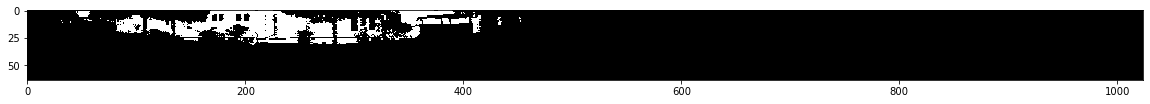

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from laserscan import *

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device = "cuda:0"
from torch.utils.data import Dataset, DataLoader
class CustomKitti(Dataset):
    def __init__(self, dir, mode="train"):
        self.ls = SemLaserScan(project=True, nclasses=100)
        self.mode = mode
        self.len = 4541
        self.train_len = 4000
        self.val_len = 300
        self.test_len = self.len - self.train_len - self.val_len
        self.label_folder = dir + "plane_labels/"
        self.file_folder = dir + "velodyne/"
    def __len__(self):
        if self.mode == "train":
            return self.train_len
        if self.mode == "val":
            return self.val_len
        return self.test_len
    def __getitem__(self, idx):
        if self.mode == "test":
            idx += self.train_len + self.val_len
        if self.mode == "val":
            idx += self.train_len
        self.ls.open_scan(self.file_folder + '{0:06d}.bin'.format(idx))
        self.ls.open_label(self.label_folder + 'label-{0:06d}.npy'.format(idx))
        self.ls.proj_sem_label[self.ls.proj_sem_label != 0] = 1
        return np.dstack((self.ls.proj_xyz, self.ls.proj_remission, self.ls.proj_range)), self.ls.proj_sem_label

training_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/") 
validation_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/", mode="val") 
test_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/", mode="test") 

batch_size = 6

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(len(training_loader))
vinputs, vlabels = next(iter(test_loader))
plt.figure(figsize=(20,80))
plt.imshow(vlabels[0], cmap="gray")
# validation_data.__len__()

In [17]:
max_classes = 2
from unet import UNet
from torch import nn
def get_model_and_optimizer(device, num_encoding_blocks=3, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    unet = UNet(
          in_channels=5,
          out_classes=max_classes,
          dimensions=2,
          num_encoding_blocks=num_encoding_blocks,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='ReLU',
      ).to(device)
    model = unet
      
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

In [18]:
criterion = nn.CrossEntropyLoss()
def train_one_epoch(epoch_index, tb_writer, optimizer, model):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = torch.tensor(inputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
        labels = torch.tensor(labels).to(device=device, dtype=torch.long)
        # print(torch.max(labels))
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # print(outputs.shape, labels.shape)
        # Compute the loss and its gradients
        # loss = torch.nn.functional.mse_loss(outputs.squeeze(), labels)
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100== 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # tb_writer.add_image("label", visualize_seg(labels.numpy(), mc).squeeze()[0], 0)
            # tb_writer.add_image("label", visualize_seg(outputs.cpu().numpy(), mc).squeeze()[0], 0)

            running_loss = 0.

    return last_loss

In [19]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_0000000.

In [20]:
model, optimizer, scheduler = get_model_and_optimizer(device)
# run_name = "SEMANTIC_log softmax_nll_"
run_name = "SEMANTIC_cross_entropy"

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, optimizer, model)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
        vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.long)

        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'chpt/model_{}_{}_{}'.format(run_name, timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/tmp/ipykernel_746799/1079947738.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
/tmp/ipykernel_746799/1079947738.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device=device, dtype=torch.long)
/home/polosatik/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_si

  batch 100 loss: 4.212091745138168
  batch 200 loss: 1.247506039738655
  batch 300 loss: 1.1085464316606521
  batch 400 loss: 1.0103137296438218
  batch 500 loss: 0.9979226067662239
  batch 600 loss: 1.0450317680835723
  batch 700 loss: 0.9360654750466346
  batch 800 loss: 0.9924322444200516
  batch 900 loss: 0.9380488410592079
  batch 1000 loss: 0.9323051631450653
  batch 1100 loss: 0.9720063826441765
  batch 1200 loss: 0.9035762988030911
  batch 1300 loss: 0.9451363319158554
  batch 1400 loss: 0.8350129601359367
  batch 1500 loss: 0.8669781392812729
  batch 1600 loss: 0.8859031039476395
  batch 1700 loss: 0.863836843073368
  batch 1800 loss: 0.8497374343872071
  batch 1900 loss: 0.8268891894817352
  batch 2000 loss: 0.858957861661911
  batch 2100 loss: 0.8484666222333908
  batch 2200 loss: 0.8097628679871559
  batch 2300 loss: 0.8269227167963982
  batch 2400 loss: 0.8082954028248787
  batch 2500 loss: 0.8496409699320793
  batch 2600 loss: 0.8667226621508598
  batch 2700 loss: 0.7957

/tmp/ipykernel_746799/11058206.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
/tmp/ipykernel_746799/11058206.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.long)


RuntimeError: CUDA out of memory. Tried to allocate 376.00 MiB (GPU 0; 7.79 GiB total capacity; 5.91 GiB already allocated; 214.12 MiB free; 6.01 GiB reserved in total by PyTorch)

In [ ]:
# model.train(False)
# model.to(device)
# vinputs, vlabels = next(iter(test_loader))
# plt.figure(figsize=(20,80))
# plt.imshow(vinputs[0][:,:, 4])
# plt.figure(figsize=(20,80))
# plt.imshow(vlabels[0])

# print(vlabels.shape, vinputs.shape)
# vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
# vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.float)
# # 201
# voutputs = model(vinputs)
# plt.figure(figsize=(20,80))
# plt.imshow(voutputs[0].cpu().permute(1,2,0).detach().numpy().squeeze())

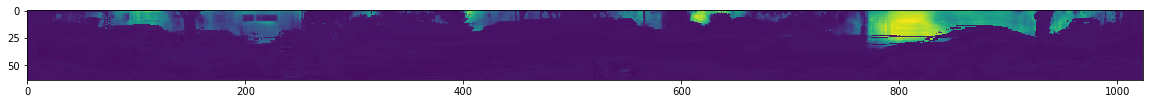

In [ ]:
plt.figure(figsize=(20,80))
plt.imshow(voutputs[0].cpu().permute(1,2,0).detach().numpy().squeeze())

In [ ]:
# running_vloss = 0.0
# for i, vdata in enumerate(test_loader):
#     vinputs, vlabels = vdata
#     vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
#     vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.float)

#     voutputs = model(vinputs)
#     vloss = torch.nn.functional.mse_loss(torch.tensor(voutputs).squeeze(), vlabels)
#     running_vloss += vloss
#     print(voutputs)

# avg_vloss = running_vloss / (i + 1)
# print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))